# Method 8 - Best Minus Rest Top 3

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 3].copy()                                                                    
short_ideas = valid_data[valid_data['pos_rank'] > 3].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

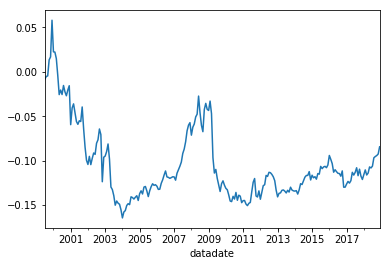

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.058139
2000-12-31   -0.069735
2001-12-31   -0.085284
2002-12-31    0.003751
2003-12-31   -0.065558
2004-12-31    0.012486
2005-12-31    0.020732
2006-12-31    0.010270
2007-12-31    0.069149
2008-12-31    0.015907
2009-12-31   -0.089198
2010-12-31   -0.022592
2011-12-31    0.015554
2012-12-31    0.000845
2013-12-31   -0.000791
2014-12-31    0.014167
2015-12-31    0.019277
2016-12-31   -0.027964
2017-12-31    0.009941
2018-12-31    0.041885
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     46.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.86e-29
Time:                        07:17:51   Log-Likelihood:                 794.11
No. Observations:                 234   AIC:                            -1578.
Df Residuals:                     229   BIC:                            -1561.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -1.031      0.303      -0.002       0.001
mktrf         -0.0230      0.015     -1.499      0.135      -0.053       0.007
me            -0.0214      0.018     -1.201      0.231      -0.057       0.014
ia            -0.1770      0.027     -6.536      0.000      -0.230      -0.124
roe            0.2179      0.023      9.399      0.000       0.172       0.264
==============================================================================
Omnibus:                       45.837   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              427.642
Skew:                          -0.351   Prob(JB):                     1.38e-93
Kurtosis:                       9.586   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     16.74
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.75e-12
Time:                        07:17:51   Log-Likelihood:                 794.11
No. Observations:                 234   AIC:                            -1578.
Df Residuals:                     229   BIC:                            -1561.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.945      0.345      -0.002       0.001
mktrf         -0.0230      0.017     -1.363      0.173      -0.056       0.010
me            -0.0214      0.033     -0.651      0.515      -0.086       0.043
ia            -0.1770      0.069     -2.577      0.010      -0.312      -0.042
roe            0.2179      0.041      5.332      0.000       0.138       0.298
==============================================================================
Omnibus:                       45.837   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              427.642
Skew:                          -0.351   Prob(JB):                     1.38e-93
Kurtosis:                       9.586   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     16.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.32e-12
Time:                        07:17:51   Log-Likelihood:                 794.11
No. Observations:                 234   AIC:                            -1578.
Df Residuals:                     229   BIC:                            -1561.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.818      0.413      -0.002       0.001
mktrf         -0.0230      0.016     -1.414      0.157      -0.055       0.009
me            -0.0214      0.037     -0.585      0.559      -0.093       0.050
ia            -0.1770      0.062     -2.847      0.004      -0.299      -0.055
roe            0.2179      0.042      5.135      0.000       0.135       0.301
==============================================================================
Omnibus:                       45.837   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              427.642
Skew:                          -0.351   Prob(JB):                     1.38e-93
Kurtosis:                       9.586   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     20.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.98e-17
Time:                        07:17:51   Log-Likelihood:                 767.75
No. Observations:                 234   AIC:                            -1523.
Df Residuals:                     228   BIC:                            -1503.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.732e-05      0.001      0.027      0.978      -0.001       0.001
mktrf         -0.0593      0.017     -3.446      0.001      -0.093      -0.025
smb           -0.0493      0.023     -2.169      0.031      -0.094      -0.005
hml           -0.0917      0.027     -3.425      0.001      -0.145      -0.039
rmw            0.1150      0.030      3.798      0.000       0.055       0.175
cma           -0.0715      0.039     -1.858      0.064      -0.147       0.004
==============================================================================
Omnibus:                       70.715   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.095
Skew:                          -0.933   Prob(JB):                    4.31e-119
Kurtosis:                      10.240   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     23.56
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.54e-19
Time:                        07:17:51   Log-Likelihood:                 767.75
No. Observations:                 234   AIC:                            -1523.
Df Residuals:                     228   BIC:                            -1503.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.732e-05      0.001      0.028      0.978      -0.001       0.001
mktrf         -0.0593      0.016     -3.648      0.000      -0.091      -0.027
smb           -0.0493      0.039     -1.275      0.202      -0.125       0.027
hml           -0.0917      0.036     -2.569      0.010      -0.162      -0.022
rmw            0.1150      0.050      2.322      0.020       0.018       0.212
cma           -0.0715      0.095     -0.756      0.450      -0.257       0.114
==============================================================================
Omnibus:                       70.715   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.095
Skew:                          -0.933   Prob(JB):                    4.31e-119
Kurtosis:                      10.240   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     27.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.05e-21
Time:                        07:17:51   Log-Likelihood:                 767.75
No. Observations:                 234   AIC:                            -1523.
Df Residuals:                     228   BIC:                            -1503.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.732e-05      0.001      0.024      0.981      -0.001       0.001
mktrf         -0.0593      0.015     -3.925      0.000      -0.089      -0.030
smb           -0.0493      0.037     -1.333      0.183      -0.122       0.023
hml           -0.0917      0.036     -2.543      0.011      -0.162      -0.021
rmw            0.1150      0.052      2.218      0.027       0.013       0.217
cma           -0.0715      0.097     -0.736      0.462      -0.262       0.119
==============================================================================
Omnibus:                       70.715   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.095
Skew:                          -0.933   Prob(JB):                    4.31e-119
Kurtosis:                      10.240   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     137.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.12e-59
Time:                        07:17:51   Log-Likelihood:                 867.37
No. Observations:                 234   AIC:                            -1725.
Df Residuals:                     229   BIC:                            -1707.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.317      0.189      -0.001       0.000
mktrf         -0.0012      0.010     -0.115      0.909      -0.022       0.019
smb           -0.1450      0.013    -11.259      0.000      -0.170      -0.120
hml           -0.0630      0.013     -4.928      0.000      -0.088      -0.038
umd            0.1574      0.008     18.754      0.000       0.141       0.174
==============================================================================
Omnibus:                       43.846   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.716
Skew:                          -0.599   Prob(JB):                     6.45e-47
Kurtosis:                       7.514   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     49.82
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.02e-30
Time:                        07:17:51   Log-Likelihood:                 867.37
No. Observations:                 234   AIC:                            -1725.
Df Residuals:                     229   BIC:                            -1707.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.090      0.276      -0.001       0.000
mktrf         -0.0012      0.015     -0.079      0.937      -0.031       0.028
smb           -0.1450      0.011    -12.798      0.000      -0.167      -0.123
hml           -0.0630      0.014     -4.534      0.000      -0.090      -0.036
umd            0.1574      0.017      9.236      0.000       0.124       0.191
==============================================================================
Omnibus:                       43.846   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.716
Skew:                          -0.599   Prob(JB):                     6.45e-47
Kurtosis:                       7.514   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     42.31
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.51e-26
Time:                        07:17:51   Log-Likelihood:                 867.37
No. Observations:                 234   AIC:                            -1725.
Df Residuals:                     229   BIC:                            -1707.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.955      0.339      -0.002       0.001
mktrf         -0.0012      0.016     -0.074      0.941      -0.032       0.030
smb           -0.1450      0.012    -12.420      0.000      -0.168      -0.122
hml           -0.0630      0.013     -4.951      0.000      -0.088      -0.038
umd            0.1574      0.018      8.658      0.000       0.122       0.193
==============================================================================
Omnibus:                       43.846   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.716
Skew:                          -0.599   Prob(JB):                     6.45e-47
Kurtosis:                       7.514   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     29.48
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.13e-17
Time:                        07:17:51   Log-Likelihood:                 385.43
No. Observations:                 120   AIC:                            -760.9
Df Residuals:                     115   BIC:                            -746.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.880      0.063      -0.004    9.57e-05
mktrf          0.0019      0.026      0.074      0.941      -0.049       0.053
me             0.0206      0.025      0.813      0.418      -0.030       0.071
ia            -0.2131      0.040     -5.368      0.000      -0.292      -0.134
roe            0.2895      0.035      8.240      0.000       0.220       0.359
==============================================================================
Omnibus:                       19.406   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.606
Skew:                           0.005   Prob(JB):                     5.24e-23
Kurtosis:                       7.530   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     23.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.60e-14
Time:                        07:17:51   Log-Likelihood:                 385.43
No. Observations:                 120   AIC:                            -760.9
Df Residuals:                     115   BIC:                            -746.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.728      0.084      -0.004       0.000
mktrf          0.0019      0.024      0.080      0.936      -0.045       0.048
me             0.0206      0.037      0.554      0.580      -0.052       0.093
ia            -0.2131      0.084     -2.540      0.011      -0.377      -0.049
roe            0.2895      0.039      7.428      0.000       0.213       0.366
==============================================================================
Omnibus:                       19.406   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.606
Skew:                           0.005   Prob(JB):                     5.24e-23
Kurtosis:                       7.530   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     24.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.44e-15
Time:                        07:17:51   Log-Likelihood:                 385.43
No. Observations:                 120   AIC:                            -760.9
Df Residuals:                     115   BIC:                            -746.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.518      0.129      -0.004       0.001
mktrf          0.0019      0.022      0.087      0.931      -0.041       0.045
me             0.0206      0.042      0.494      0.622      -0.061       0.102
ia            -0.2131      0.078     -2.739      0.006      -0.365      -0.061
roe            0.2895      0.036      8.070      0.000       0.219       0.360
==============================================================================
Omnibus:                       19.406   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.606
Skew:                           0.005   Prob(JB):                     5.24e-23
Kurtosis:                       7.530   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     9.173
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.33e-07
Time:                        07:17:51   Log-Likelihood:                 363.36
No. Observations:                 120   AIC:                            -714.7
Df Residuals:                     114   BIC:                            -698.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.946      0.346      -0.003       0.001
mktrf         -0.0670      0.033     -2.051      0.043      -0.132      -0.002
smb           -0.0119      0.037     -0.321      0.749      -0.085       0.061
hml           -0.1161      0.045     -2.561      0.012      -0.206      -0.026
rmw            0.1566      0.053      2.930      0.004       0.051       0.263
cma           -0.0773      0.059     -1.320      0.190      -0.193       0.039
==============================================================================
Omnibus:                       24.920   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.373
Skew:                          -0.655   Prob(JB):                     3.53e-18
Kurtosis:                       6.789   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     11.54
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.97e-09
Time:                        07:17:51   Log-Likelihood:                 363.36
No. Observations:                 120   AIC:                            -714.7
Df Residuals:                     114   BIC:                            -698.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.898      0.369      -0.004       0.001
mktrf         -0.0670      0.033     -2.025      0.043      -0.132      -0.002
smb           -0.0119      0.053     -0.225      0.822      -0.115       0.091
hml           -0.1161      0.050     -2.325      0.020      -0.214      -0.018
rmw            0.1566      0.063      2.467      0.014       0.032       0.281
cma           -0.0773      0.113     -0.685      0.493      -0.299       0.144
==============================================================================
Omnibus:                       24.920   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.373
Skew:                          -0.655   Prob(JB):                     3.53e-18
Kurtosis:                       6.789   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     15.00
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.65e-11
Time:                        07:17:51   Log-Likelihood:                 363.36
No. Observations:                 120   AIC:                            -714.7
Df Residuals:                     114   BIC:                            -698.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.773      0.440      -0.004       0.002
mktrf         -0.0670      0.033     -2.050      0.040      -0.131      -0.003
smb           -0.0119      0.048     -0.249      0.803      -0.105       0.082
hml           -0.1161      0.048     -2.421      0.015      -0.210      -0.022
rmw            0.1566      0.061      2.560      0.010       0.037       0.277
cma           -0.0773      0.115     -0.670      0.503      -0.303       0.149
==============================================================================
Omnibus:                       24.920   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.373
Skew:                          -0.655   Prob(JB):                     3.53e-18
Kurtosis:                       6.789   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     90.12
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.60e-34
Time:                        07:17:51   Log-Likelihood:                 428.24
No. Observations:                 120   AIC:                            -846.5
Df Residuals:                     115   BIC:                            -832.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.418      0.159      -0.002       0.000
mktrf          0.0155      0.016      0.982      0.328      -0.016       0.047
smb           -0.1561      0.018     -8.665      0.000      -0.192      -0.120
hml           -0.0676      0.018     -3.745      0.000      -0.103      -0.032
umd            0.1790      0.011     16.084      0.000       0.157       0.201
==============================================================================
Omnibus:                       17.168   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.826
Skew:                          -0.498   Prob(JB):                     1.36e-09
Kurtosis:                       5.678   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     34.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.07e-19
Time:                        07:17:51   Log-Likelihood:                 428.24
No. Observations:                 120   AIC:                            -846.5
Df Residuals:                     115   BIC:                            -832.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.167      0.243      -0.002       0.001
mktrf          0.0155      0.018      0.848      0.397      -0.020       0.051
smb           -0.1561      0.014    -10.856      0.000      -0.184      -0.128
hml           -0.0676      0.015     -4.626      0.000      -0.096      -0.039
umd            0.1790      0.018      9.745      0.000       0.143       0.215
==============================================================================
Omnibus:                       17.168   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.826
Skew:                          -0.498   Prob(JB):                     1.36e-09
Kurtosis:                       5.678   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     34.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.63e-19
Time:                        07:17:51   Log-Likelihood:                 428.24
No. Observations:                 120   AIC:                            -846.5
Df Residuals:                     115   BIC:                            -832.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.008      0.314      -0.003       0.001
mktrf          0.0155      0.018      0.846      0.397      -0.020       0.052
smb           -0.1561      0.015    -10.129      0.000      -0.186      -0.126
hml           -0.0676      0.014     -4.745      0.000      -0.095      -0.040
umd            0.1790      0.018      9.978      0.000       0.144       0.214
==============================================================================
Omnibus:                       17.168   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.826
Skew:                          -0.498   Prob(JB):                     1.36e-09
Kurtosis:                       5.678   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     31.80
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-17
Time:                        07:17:51   Log-Likelihood:                 455.06
No. Observations:                 114   AIC:                            -900.1
Df Residuals:                     109   BIC:                            -886.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.288      0.201      -0.000       0.001
mktrf         -0.0302      0.013     -2.244      0.027      -0.057      -0.004
me            -0.1249      0.021     -6.023      0.000      -0.166      -0.084
ia            -0.1170      0.029     -4.067      0.000      -0.174      -0.060
roe            0.0688      0.025      2.721      0.008       0.019       0.119
==============================================================================
Omnibus:                        5.968   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.316
Skew:                           0.191   Prob(JB):                       0.0156
Kurtosis:                       4.267   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     43.42
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.55e-22
Time:                        07:17:51   Log-Likelihood:                 455.06
No. Observations:                 114   AIC:                            -900.1
Df Residuals:                     109   BIC:                            -886.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.482      0.138      -0.000       0.001
mktrf         -0.0302      0.013     -2.291      0.022      -0.056      -0.004
me            -0.1249      0.022     -5.597      0.000      -0.169      -0.081
ia            -0.1170      0.037     -3.146      0.002      -0.190      -0.044
roe            0.0688      0.024      2.842      0.004       0.021       0.116
==============================================================================
Omnibus:                        5.968   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.316
Skew:                           0.191   Prob(JB):                       0.0156
Kurtosis:                       4.267   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     54.52
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.65e-25
Time:                        07:17:51   Log-Likelihood:                 455.06
No. Observations:                 114   AIC:                            -900.1
Df Residuals:                     109   BIC:                            -886.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.457      0.145      -0.000       0.001
mktrf         -0.0302      0.013     -2.280      0.023      -0.056      -0.004
me            -0.1249      0.022     -5.690      0.000      -0.168      -0.082
ia            -0.1170      0.042     -2.817      0.005      -0.198      -0.036
roe            0.0688      0.023      3.050      0.002       0.025       0.113
==============================================================================
Omnibus:                        5.968   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.316
Skew:                           0.191   Prob(JB):                       0.0156
Kurtosis:                       4.267   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     30.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.01e-19
Time:                        07:17:51   Log-Likelihood:                 460.91
No. Observations:                 114   AIC:                            -909.8
Df Residuals:                     108   BIC:                            -893.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.564      0.121      -0.000       0.002
mktrf         -0.0338      0.012     -2.764      0.007      -0.058      -0.010
smb           -0.1269      0.020     -6.394      0.000      -0.166      -0.088
hml           -0.0607      0.025     -2.398      0.018      -0.111      -0.011
rmw            0.0321      0.031      1.034      0.303      -0.029       0.094
cma           -0.0823      0.039     -2.091      0.039      -0.160      -0.004
==============================================================================
Omnibus:                        3.914   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                4.607
Skew:                           0.082   Prob(JB):                       0.0999
Kurtosis:                       3.971   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     102.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.44e-39
Time:                        07:17:52   Log-Likelihood:                 460.91
No. Observations:                 114   AIC:                            -909.8
Df Residuals:                     108   BIC:                            -893.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.351      0.019       0.000       0.001
mktrf         -0.0338      0.012     -2.800      0.005      -0.057      -0.010
smb           -0.1269      0.016     -7.894      0.000      -0.158      -0.095
hml           -0.0607      0.022     -2.750      0.006      -0.104      -0.017
rmw            0.0321      0.030      1.082      0.279      -0.026       0.090
cma           -0.0823      0.043     -1.915      0.056      -0.167       0.002
==============================================================================
Omnibus:                        3.914   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                4.607
Skew:                           0.082   Prob(JB):                       0.0999
Kurtosis:                       3.971   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     98.94
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-38
Time:                        07:17:52   Log-Likelihood:                 460.91
No. Observations:                 114   AIC:                            -909.8
Df Residuals:                     108   BIC:                            -893.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.417      0.016       0.000       0.001
mktrf         -0.0338      0.012     -2.752      0.006      -0.058      -0.010
smb           -0.1269      0.016     -7.752      0.000      -0.159      -0.095
hml           -0.0607      0.021     -2.945      0.003      -0.101      -0.020
rmw            0.0321      0.031      1.044      0.297      -0.028       0.092
cma           -0.0823      0.045     -1.838      0.066      -0.170       0.005
==============================================================================
Omnibus:                        3.914   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                4.607
Skew:                           0.082   Prob(JB):                       0.0999
Kurtosis:                       3.971   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     50.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.00e-24
Time:                        07:17:52   Log-Likelihood:                 470.50
No. Observations:                 114   AIC:                            -931.0
Df Residuals:                     109   BIC:                            -917.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.905      0.367      -0.000       0.001
mktrf         -0.0249      0.011     -2.241      0.027      -0.047      -0.003
smb           -0.1381      0.017     -7.964      0.000      -0.172      -0.104
hml           -0.0770      0.018     -4.310      0.000      -0.112      -0.042
umd            0.0714      0.013      5.303      0.000       0.045       0.098
==============================================================================
Omnibus:                        0.842   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.411
Skew:                           0.023   Prob(JB):                        0.814
Kurtosis:                       3.291   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     77.35
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.02e-31
Time:                        07:17:52   Log-Likelihood:                 470.50
No. Observations:                 114   AIC:                            -931.0
Df Residuals:                     109   BIC:                            -917.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.552      0.121   -9.42e-05       0.001
mktrf         -0.0249      0.009     -2.740      0.006      -0.043      -0.007
smb           -0.1381      0.020     -6.987      0.000      -0.177      -0.099
hml           -0.0770      0.014     -5.381      0.000      -0.105      -0.049
umd            0.0714      0.013      5.403      0.000       0.046       0.097
==============================================================================
Omnibus:                        0.842   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.411
Skew:                           0.023   Prob(JB):                        0.814
Kurtosis:                       3.291   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.08e-37
Time:                        07:17:52   Log-Likelihood:                 470.50
No. Observations:                 114   AIC:                            -931.0
Df Residuals:                     109   BIC:                            -917.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.009      0.045    8.71e-06       0.001
mktrf         -0.0249      0.009     -2.708      0.007      -0.043      -0.007
smb           -0.1381      0.021     -6.596      0.000      -0.179      -0.097
hml           -0.0770      0.013     -5.871      0.000      -0.103      -0.051
umd            0.0714      0.015      4.750      0.000       0.042       0.101
==============================================================================
Omnibus:                        0.842   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.411
Skew:                           0.023   Prob(JB):                        0.814
Kurtosis:                       3.291   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""